In [ ]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.utils.vis_utils import plot_model
from numpy.random import seed
from itertools import chain
from tensorflow.keras import Model,Input
from tensorflow.keras.layers import LSTM,Embedding,Dense
from tensorflow.keras.layers import TimeDistributed, SpatialDropout1D,Bidirectional

plt.style.use('seaborn')

In [ ]:
# getting the data
from google.colab import files
uploaded = files.upload()

In [ ]:
# drop the POS column because we dont need it
data = data.drop('POS', 1)

In [ ]:
print(data.head())
print("shape of dataset: " , data.shape)

    Sentence #           Word Tag
0  Sentence: 1      Thousands   O
1          NaN             of   O
2          NaN  demonstrators   O
3          NaN           have   O
4          NaN        marched   O
shape of dataset:  (1048575, 3)


In [ ]:
# Fill na
data = data.fillna(method = 'ffill')
print(data.head())

    Sentence #           Word Tag
0  Sentence: 1      Thousands   O
1  Sentence: 1             of   O
2  Sentence: 1  demonstrators   O
3  Sentence: 1           have   O
4  Sentence: 1        marched   O


In [ ]:
words = list(set(data["Word"].values))
words.append("ENDPAD")
num_words = len(words)

print(words)
print(f"Total number of unique words in dataset: {num_words}")

['Francesca', 'dishonest', 'fundraiser', 'Aristide', 'Kenyan', 'gravel', 'no-win', 'Baleno', 'decides', 'Benshoofin', 'Hogg', 'postwar', 'Wikipedia', 'damages', 'celebrations', 'Shanghai', '2013', 'Bart', 'wretched', 'spacewalking', 'evacuate', 'trespassing', 'renounces', 'director-general', 'Kimi', 'Gardens', 'Brian', 'militiamen', 'Erich', '6,500', 'Mukhtar', 'widows', 'rightists', 'riders', 'offered', 'insurgency-related', 'pro-reunification', 'Division', 'newborn', 'double-bombing', 'baboons', 'transmit', 'compassionate', "'re", 'managerial', 'Dmitry', 'Tri', 'Jubran', '188', 'perched', 'Barot', 'Chirac', 'TIME', 'repayment', 'dynasties', 'rafts', 'Lindsey', 'Rignot', '66', 'Junaid', 'Cheek', 'Outer', 'Pokhrel', 'triple-jump', 'intoxicating', 'Danilo', 'Tynychbek', 'fractions', 'Silver', 'observe', 'AFP', 'redeployed', 'Khujand', 'budgeted', 'Manchuria', 'verbally', 'pierced', 'Market', 'neglect', 'pensions', 'denial', 'payable', 'CONVENTION', 'el-Mallahi', 'Afghans', 'teacher', 'T

In [ ]:
tags = list(set(data["Tag"].values))
num_tags = len(tags)
num_tags
print("List of tags: " + ', '.join([tag for tag in tags]))
print(f"Total Number of tags {num_tags}")

List of tags: I-tim, I-org, I-eve, B-tim, B-geo, I-gpe, B-eve, B-gpe, B-nat, B-art, I-nat, B-per, I-art, I-per, I-geo, O, B-org
Total Number of tags 17


In [ ]:
class Get_sentence(object):
    def __init__(self,data):
        self.n_sent = 1
        self.data = data
        agg_func = lambda s:[(w, t) for w, t in zip(s["Word"].values.tolist(),
                                                    s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]

In [ ]:
getter = Get_sentence(data)
sentence = getter.sentences

In [ ]:
sentence[100]

[('She', 'O'),
 ('was', 'O'),
 ('a', 'O'),
 ('longtime', 'O'),
 ('member', 'O'),
 ('of', 'O'),
 ('the', 'O'),
 ('Zapatista', 'B-geo'),
 ('movement', 'O'),
 ('and', 'O'),
 ('appeared', 'O'),
 ('in', 'O'),
 ('public', 'O'),
 ('wearing', 'O'),
 ('a', 'O'),
 ('black', 'O'),
 ('ski', 'O'),
 ('mask', 'O'),
 ('.', 'O')]

Number of Sentences: 47959
Maximum sequence length: 104
Number of unique words: 35179


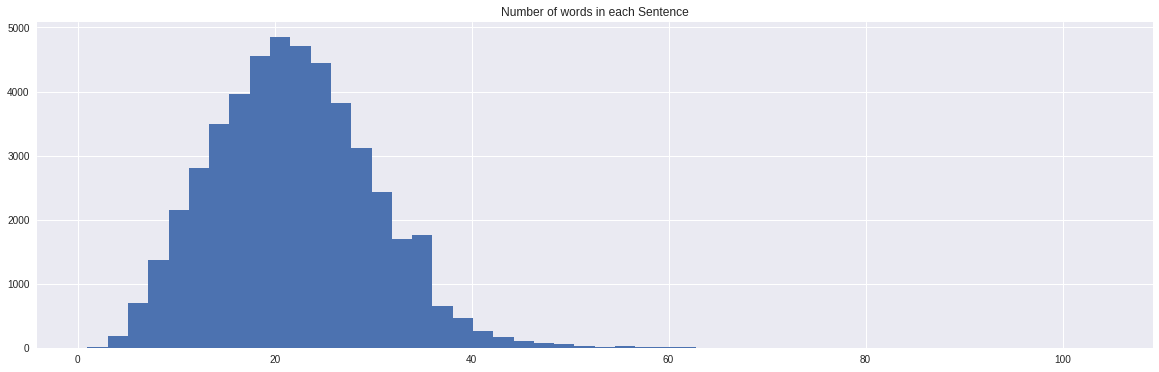

In [ ]:
fig, ax = plt.subplots(figsize=(20, 6))
ax.hist([len(s) for s in sentence], bins=50)
ax.set_title('Number of words in each Sentence')

maxlen = max([len(s) for s in sentence])
print('Number of Sentences:', len(sentence))
print ('Maximum sequence length:', maxlen)

words = list(set(data["Word"].values))
words.append("ENDPAD")
n_words = len(words)
print('Number of unique words:', n_words)

Number of unique Tags: 17


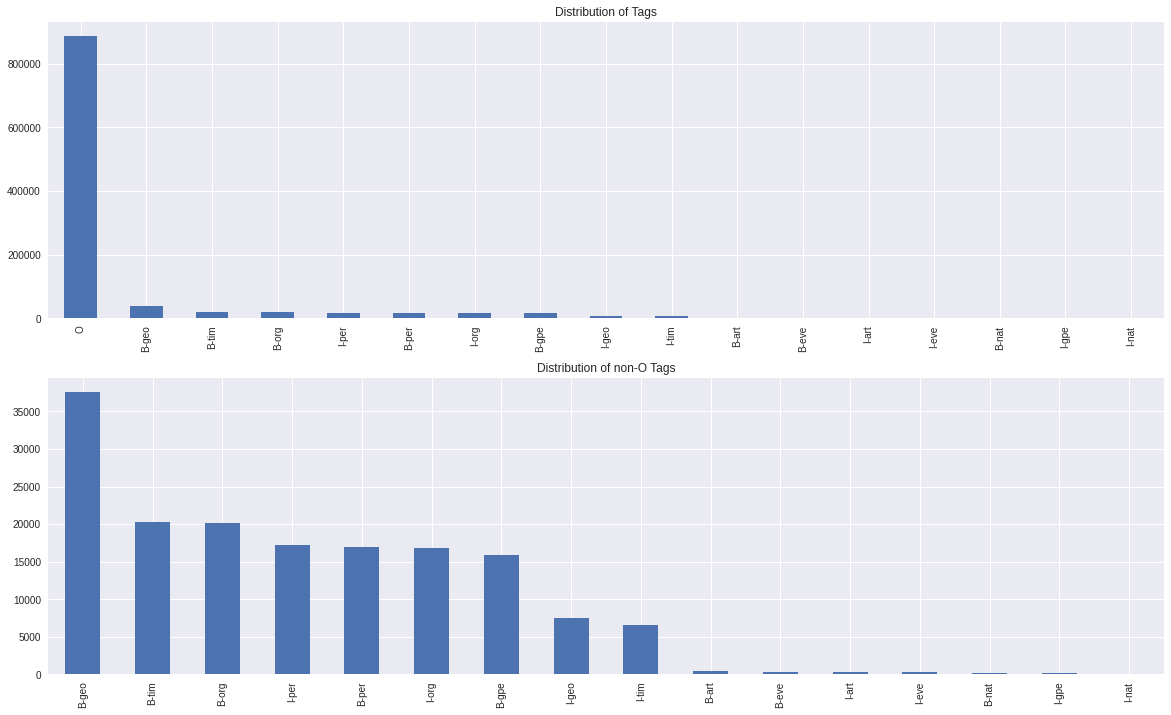

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(20, 12))
data.Tag.value_counts().plot.bar(ax=ax[0], title='Distribution of Tags')
data[data.Tag != 'O'].Tag.value_counts().plot.bar(ax=ax[1], title='Distribution of non-O Tags')

tags = list(set(data["Tag"].values))
n_tags = len(tags)
print('Number of unique Tags:', n_tags)

In [ ]:
word_idx = {w : i + 1 for i ,w in enumerate(words)}
tag_idx =  {t : i for i ,t in enumerate(tags)}

In [ ]:
print(word_idx)
print(tag_idx)

{'Francesca': 1, 'dishonest': 2, 'fundraiser': 3, 'Aristide': 4, 'Kenyan': 5, 'gravel': 6, 'no-win': 7, 'Baleno': 8, 'decides': 9, 'Benshoofin': 10, 'Hogg': 11, 'postwar': 12, 'Wikipedia': 13, 'damages': 14, 'celebrations': 15, 'Shanghai': 16, '2013': 17, 'Bart': 18, 'wretched': 19, 'spacewalking': 20, 'evacuate': 21, 'trespassing': 22, 'renounces': 23, 'director-general': 24, 'Kimi': 25, 'Gardens': 26, 'Brian': 27, 'militiamen': 28, 'Erich': 29, '6,500': 30, 'Mukhtar': 31, 'widows': 32, 'rightists': 33, 'riders': 34, 'offered': 35, 'insurgency-related': 36, 'pro-reunification': 37, 'Division': 38, 'newborn': 39, 'double-bombing': 40, 'baboons': 41, 'transmit': 42, 'compassionate': 43, "'re": 44, 'managerial': 45, 'Dmitry': 46, 'Tri': 47, 'Jubran': 48, '188': 49, 'perched': 50, 'Barot': 51, 'Chirac': 52, 'TIME': 53, 'repayment': 54, 'dynasties': 55, 'rafts': 56, 'Lindsey': 57, 'Rignot': 58, '66': 59, 'Junaid': 60, 'Cheek': 61, 'Outer': 62, 'Pokhrel': 63, 'triple-jump': 64, 'intoxicatin

# Model

In [ ]:
from keras.models import Sequential
from keras.layers import Input, Embedding,TimeDistributed, LSTM, Dropout, Bidirectional, Dense 
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.utils import plot_model, to_categorical

In [ ]:
X = [[word_idx[w[0]] for w in s] for s in sentence]
X = sequence.pad_sequences(maxlen=maxlen, sequences=X, padding="post",value=n_words - 1)

y = [[tag_idx[w[1]] for w in s] for s in sentence]
y = sequence.pad_sequences(maxlen=maxlen, sequences=y, padding="post", value=tag_idx["O"])
y = np.array([to_categorical(i, num_classes=n_tags) for i in y])

print('X shape', X.shape, 'y shape', y.shape)

X shape (47959, 104) y shape (47959, 104, 17)


In [ ]:
x_train,x_test,y_train,y_test = train_test_split(X, y,test_size = 0.20, random_state = 1)

In [ ]:
 class config():
    VOCAB = n_words   #unique words
    MAX_LEN = maxlen  
    N_OUPUT = n_tags  
    
    
    EMBEDDING_VECTOR_LENGTH = 64
    N_LSTM_CELLS = 128
    RECURRENT_DROPOUT = 0.2
    
    OUTPUT_ACTIVATION = 'softmax'
    
    LOSS = 'categorical_crossentropy'
    OPTIMIZER = 'adam'
    METRICS = ['accuracy']
    
    MAX_EPOCHS = 5

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 104, 64)           2251456   
_________________________________________________________________
bidirectional (Bidirectional (None, 104, 256)          197632    
_________________________________________________________________
time_distributed (TimeDistri (None, 104, 17)           4369      
Total params: 2,453,457
Trainable params: 2,453,457
Non-trainable params: 0
_________________________________________________________________


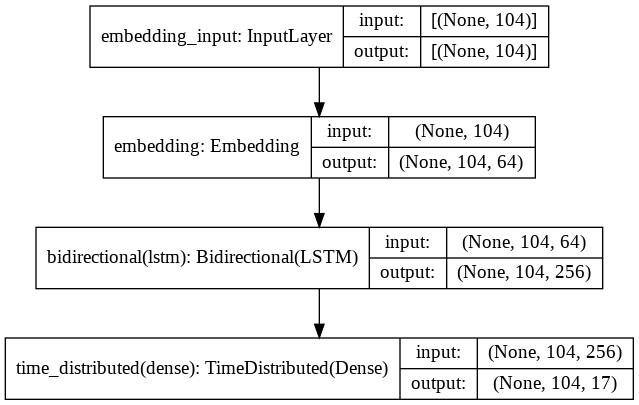

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=7)
#filepath = "model.h5"
#ckpt = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
#rlp = ReduceLROnPlateau(monitor='loss', patience=3, verbose=1)

model = Sequential()
model.add(
    Embedding(
        input_dim=config.VOCAB, output_dim=config.EMBEDDING_VECTOR_LENGTH, input_length=config.MAX_LEN
    )
)
model.add(
    Bidirectional(
        LSTM(config.N_LSTM_CELLS, return_sequences=True, recurrent_dropout=config.RECURRENT_DROPOUT)
    )
)
model.add(
    TimeDistributed(
        Dense(config.N_OUPUT, activation=config.OUTPUT_ACTIVATION)
    )
)
model.compile(loss=config.LOSS, optimizer=config.OPTIMIZER, metrics=config.METRICS)

model.summary()
plot_model(model, show_shapes=True)

In [ ]:
history = model.fit(x=X, y=y, batch_size = 64, validation_split=0.25,
    #callbacks=[es, ckpt, rlp], epochs=config.MAX_EPOCHS
    callbacks=es, epochs=config.MAX_EPOCHS
    
)

Epoch 1/5
563/563 [==============================] - 382s 671ms/step - loss: 0.3382 - accuracy: 0.9573 - val_loss: 0.0607 - val_accuracy: 0.9832
Epoch 2/5
563/563 [==============================] - 385s 683ms/step - loss: 0.0457 - accuracy: 0.9874 - val_loss: 0.0304 - val_accuracy: 0.9913
Epoch 3/5
563/563 [==============================] - 377s 671ms/step - loss: 0.0232 - accuracy: 0.9933 - val_loss: 0.0273 - val_accuracy: 0.9919
Epoch 4/5
563/563 [==============================] - 378s 671ms/step - loss: 0.0176 - accuracy: 0.9947 - val_loss: 0.0269 - val_accuracy: 0.9922
Epoch 5/5
563/563 [==============================] - 381s 677ms/step - loss: 0.0146 - accuracy: 0.9955 - val_loss: 0.0277 - val_accuracy: 0.9922


In [ ]:
model.evaluate(x_test,y_test)

300/300 [==============================] - 19s 63ms/step - loss: 0.0161 - accuracy: 0.9952


[0.0161102507263422, 0.9951832890510559]

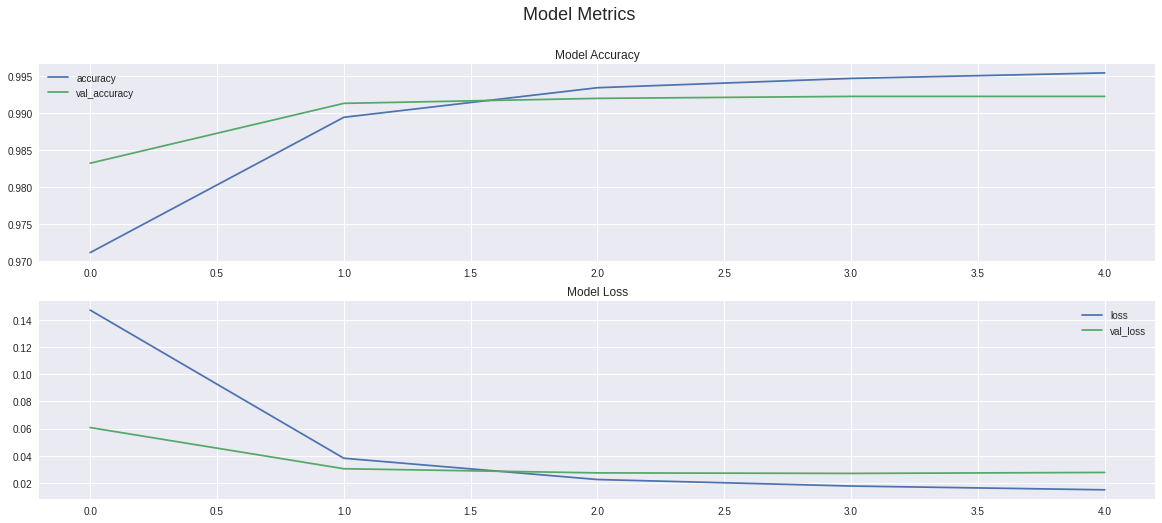

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(20, 8))
df = pd.DataFrame(history.history)
df[['accuracy', 'val_accuracy']].plot(ax=ax[0])
df[['loss', 'val_loss']].plot(ax=ax[1])
ax[0].set_title('Model Accuracy', fontsize=12)
ax[1].set_title('Model Loss', fontsize=12)
fig.suptitle('Model Metrics', fontsize=18);


In [ ]:
i = np.random.randint(0, X.shape[0])
p = model.predict(np.array([X[i]]))
p = np.argmax(p, axis=-1)
y_true = np.argmax(y, axis=-1)[i]

print(f"{'Word':15}{'True':5}\t{'Pred'}")
print("-"*30)
for (w, t, pred) in zip(X[i], y_true, p[0]):
    print(f"{words[w]:15}{tags[t]}\t{tags[pred]}")
    if words[w] == 'ENDPAD': 
        break

Word           True 	Pred
------------------------------
beatboxing     O	O
underfunding   O	O
bags           O	O
secularists    O	O
Zaman          O	O
hardened       O	O
Wolde-Michael  B-geo	I-geo
options        O	O
neighbour      O	O
Nazarov        O	O
Documents      B-org	B-org
rehabilitation O	O
Erzurum        O	O
crocodile      O	O
forgive        B-gpe	B-gpe
Toshiyuki      O	O
martyrs        O	O
bury           O	O
relocate       O	O
forgive        B-gpe	B-gpe
fourth-highest O	O
Recovery       O	O
ENDPAD         O	O


In [ ]:
!pip install seqeval

     |████████████████████████████████| 51kB 2.6MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-cp36-none-any.whl size=16171 sha256=4dd5d22cf5fae14367d4bc1659615399ab296420a759153647d4ac7b3bdf0c9e
  Stored in directory: /root/.cache/pip/wheels/52/df/1b/45d75646c37428f7e626214704a0e35bd3cfc32eda37e59e5f
Successfully built seqeval


In [ ]:
from seqeval.metrics import precision_score, recall_score, f1_score, classification_report


In [ ]:
test_pred = model.predict(x_test, verbose=1)

300/300 [==============================] - 18s 62ms/step


In [ ]:
idx_tag = {i: w for w, i in tag_idx.items()}

def pred2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(idx_tag[p_i].replace("PAD", "O"))
        out.append(out_i)
    return out
    
pred_labels = pred2label(test_pred)
test_labels = pred2label(y_test)

In [ ]:
print("F1-score: {:.1%}".format(f1_score(test_labels, pred_labels)))
print(classification_report(test_labels, pred_labels))

F1-score: 85.6%
              precision    recall  f1-score   support

         art       0.44      0.04      0.08        96
         eve       0.50      0.06      0.11        79
         geo       0.84      0.94      0.89      7382
         gpe       0.97      0.93      0.95      3176
         nat       1.00      0.03      0.05        40
         org       0.78      0.71      0.74      3910
         per       0.82      0.81      0.82      3362
         tim       0.88      0.89      0.88      4107

   micro avg       0.85      0.86      0.86     22152
   macro avg       0.78      0.55      0.56     22152
weighted avg       0.85      0.86      0.85     22152

